In [22]:
!pip -q install monai
!pip -q install segmentation-models-pytorch==0.2.1
# !pip -q install ../input/pylibjpeg140py3/pylibjpeg-1.4.0-py3-none-any.whl
# !pip -q install ../input/pylibjpeg140py3/python_gdcm-3.0.17.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

In [29]:
DEBUG = False
import os
import sys
import gc
import ast
import cv2
import time
import timm
import pickle
import random
import pydicom
import argparse
import warnings
import numpy as np
import pandas as pd
from glob import glob
import nibabel as nib
from PIL import Image
from tqdm import tqdm
import albumentations
from pylab import rcParams
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from monai.transforms import Resize
import  monai.transforms as transforms

%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device('cuda')
torch.backends.cudnn.benchmark = True

In [207]:
# sys.path = ['../input/covn3d-same'] + sys.path
from timm.models.layers.conv2d_same import Conv2dSame
from conv3D_same import Conv3dSame
from typing import Any, Dict, Optional

Config

In [339]:
kernel_type = 'timm3d_res18d_unet4b_128_128_128_dsv2_flip12_shift333p7_gd1p5_bs4_lr3e4_20x50ep'
load_kernel = None
load_last = True
n_blocks = 4
n_folds = 5
backbone = 'resnet18d'

image_sizes = [128,128,128] #size of Unet
R = Resize(image_sizes)

init_lr = 3e-3
batch_size = 4
drop_rate = 0.
drop_path_rate = 0.
loss_weights = [1, 1]
p_mixup = 0.1

data_dir = '/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan_Dataset'
use_amp = True
num_workers = 4
out_dim = 7

n_epochs = 1000
log_dir = './logs'
model_dir = './models'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [340]:
transforms_train = transforms.Compose([
    transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=1),
    transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=2),
    transforms.RandAffined(keys=["image", "mask"], translate_range=[int(x*y) for x, y in zip(image_sizes, [0.3, 0.3, 0.3])], padding_mode='zeros', prob=0.7),
    transforms.RandGridDistortiond(keys=("image", "mask"), prob=0.5, distort_limit=(-0.01, 0.01), mode="nearest"),    
])

transforms_valid = transforms.Compose([
])

In [686]:
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
df_train.head()
mask_files = os.listdir(f'{data_dir}/Masks')
df_mask = pd.DataFrame({
    'mask_file': sorted(mask_files)
})
df_mask = df_mask[1:] 
df_mask = df_mask.reset_index(drop = True)
df_mask['Folder Names'] = df_mask['mask_file'].apply(lambda x: x[:-5])
df_mask['mask_file'] = df_mask['mask_file'].apply(lambda x: os.path.join(data_dir,'Masks',x))
df = df_train.merge(df_mask, on = 'Folder Names', how = 'left')
df.head()
df['image_folder'] = df['Folder Names'].apply(lambda x: os.path.join(data_dir, 'Deidentified_Scans', x+'_1'))
df['mask_file'].fillna('', inplace = True)
df.rename(columns = {'Folder Names' : 'FolderNames'}, inplace = True)
df_seg = df.query('mask_file !=""').reset_index(drop=True)
# df_seg
# df_seg['image_folder'][0]
#df_seg['mask_file'][0]

'/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan_Dataset/Masks/CT01_mask'

DataFrame

Dataset

In [343]:
revert_list = [
    'CT01',
    'CT02',
    'CT03',
    'CT04',
    'CT05'
]

In [268]:
# import glob
# filepath = "/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan_Dataset/Deidentified Scans/CT10_1/*"
# counttag = {}
# for fname in glob.glob(filepath):
#     ax = pydicom.dcmread(fname)
#     for num in ax:
#         if str(num.tag) == '(0020, 000d)':
#             tag_value = str(ax[num.tag].value)
#             counttag[tag_value] = counttag.get(tag_value, 0) + 1
# print(counttag)

# dicom = pydicom.read_file(path)
# counttag = []
# for num in dicom:
#         if str(num.tag) == '(0020, 000d)':
#             counttag.append(str(ax[num.tag].value))
# print(counttag)

In [691]:
class SEGDataset(Dataset):
    def __init__(self, df, mode, transform):

        self.df = df.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        ### using local cache
        # image_file = os.path.join(data_dir, f'Deidentified Scans/{row.FolderNames}_1')
        # mask_file = os.path.join(data_dir, f'Masks/{row.FolderNames}_mask')
        # image = np.load(image_file).astype(np.float32)
        # mask = np.load(mask_file).astype(np.float32)
        path = self.df.iloc[index]['image_folder']
        pathmask =self.df.iloc[index]['mask_file']
        # List of tuples, each tuple contains file path and corresponding DICOM tag (0020, 0013) value
        t_paths_with_tags = []
        # m_scans = len(m_paths_sorted)
        # indicess = np.quantile(list(range(m_scans)), np.linspace(0., 1., image_sizes[2])).round().astype(int)
        # m_paths_sorted = [m_paths_sorted[i] for i in indicess]
        # Extract DICOM tag values for all mask files
        for image_path in glob(os.path.join(path, "*")):
            image_ds = pydicom.dcmread(image_path)
            image_elem = next((elem for elem in image_ds if str(elem.tag) == '(0020, 0013)'), None)
            if image_elem is not None:
                t_paths_with_tags.append((image_path, int(image_elem.value)))

        print("Before sorting:", t_paths_with_tags)
        t_paths_with_tags.sort(key=lambda x: x[1])  # Sorting based on DICOM tag values
        print("After sorting:", t_paths_with_tags)

        # Get the sorted file paths
        t_paths_sorted = [path for path, _ in t_paths_with_tags]
        print(t_paths_sorted[:5])
        images = []
        resized_images = [cv2.resize(pydicom.dcmread(s).pixel_array, (image_sizes[0], image_sizes[1]), interpolation = cv2.INTER_LINEAR) for s in t_paths_sorted]
        print([pydicom.dcmread(s).InstanceNumber for s in t_paths_sorted[:5]])
        images = np.stack(resized_images, -1)
        # images = np.stack(images, -1)
        images = images - np.min(images)
        images = images / (np.max(images) + 1e-4)
        images = (images * 255).astype(np.uint8)
        if images.ndim < 4:
            image = np.expand_dims(images, 0).repeat(3, 0)  # from single channel which is less than 4 dimension to 3 channels
#########################
        
        # List of tuples, each tuple contains file path and corresponding DICOM tag (0020, 0013) value
        m_paths_with_tags = []

        # Extract DICOM tag values for all mask files
        for mask_path in glob(os.path.join(pathmask, "*")):
            mask_ds = pydicom.dcmread(mask_path)
            mask_elem = next((elem for elem in mask_ds if str(elem.tag) == '(0020, 0013)'), None)
            if mask_elem is not None:
                m_paths_with_tags.append((mask_path, int(mask_elem.value)))

        print("Before sorting:", m_paths_with_tags)
        # Sort the file paths based on the DICOM tag values in ascending order
        m_paths_with_tags.sort(key=lambda x: x[1])
        print("After sorting:", m_paths_with_tags)

        # Get the sorted file paths
        m_paths_sorted = [pathmask for pathmask, _ in m_paths_with_tags]
        # m_scans = len(m_paths_sorted)
        # indicess = np.quantile(list(range(m_scans)), np.linspace(0., 1., image_sizes[2])).round().astype(int)
        # m_paths_sorted = [m_paths_sorted[i] for i in indicess]
        print(m_paths_sorted[:5])
        masks = []
        resized_masks = [cv2.resize(pydicom.dcmread(s).pixel_array, (image_sizes[0], image_sizes[1]), interpolation = cv2.INTER_LINEAR) for s in m_paths_sorted]
        print([pydicom.dcmread(s).InstanceNumber for s in m_paths_sorted[:5]])
        masks = np.stack(resized_masks, -1)
        mask_org = masks
        shape = mask_org.shape
        mask_org = mask_org.transpose(1, 0, 2)[::-1, :, ::-1]  # (d, w, h)
        mask = np.zeros((7, shape[0], shape[1], shape[2]))
        for cid in range(7):
            mask[cid] = (mask_org == (cid+1))
        mask = mask.astype(np.uint8) * 255
        mask = R(mask).numpy()
        
        # if self.df.iloc[index]['FolderNames'] in revert_list:
        #     mask = mask[:, :, :, ::-1]
        # Assuming you have sorted t_paths and m_paths correctly
        for img_path, mask_path in zip(t_paths_sorted, m_paths_sorted):
            img_ds = pydicom.dcmread(img_path)
            mask_ds = pydicom.dcmread(mask_path)
            img_elem = next((elem for elem in img_ds if str(elem.tag) == '(0020, 0013)'), None)
            mask_elem = next((elem for elem in mask_ds if str(elem.tag) == '(0020, 0013)'), None)
            if img_elem is not None and mask_elem is not None:
                print(f"Image: {img_elem.value}, Mask: {mask_elem.value}")


        res = self.transform({'image':image, 'mask':mask})
        image = res['image'] / 255.
        mask = res['mask'].astype(np.float32)
        mask = (mask > 127).astype(np.float32)
        image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
        return image, mask

In [692]:
# def load_dicom(path):
#     dicom = pydicom.read_file(path)
#     data = dicom.pixel_array
#     data = cv2.resize(data, (image_sizes[0], image_sizes[1]), interpolation = cv2.INTER_LINEAR)
#     return data

# def load_dicom_line_par(path):

#     t_paths = sorted(glob(os.path.join(path, "/*")))
#     print("Total Files:", len(t_paths))
#     print("Example File Path:", t_paths[0])
#     n_scans = len(t_paths)
#     indices = np.quantile(list(range(n_scans)), np.linspace(0., 1., image_sizes[2])).round().astype(int)
#     t_paths = [t_paths[i] for i in indices]

#     images = []
#     for filename in t_paths:
#         images.append(load_dicom(filename))
#     images = np.stack(images, -1)
#     images = images - np.min(images)
#     images = images / (np.max(images) + 1e-4)
#     images = (images * 255).astype(np.uint8)

#     return images


# def load_sample(row, has_mask=True):

#     image = load_dicom_line_par(row.image_folder)
#     print(row.image_folder)
#     if image.ndim < 4:
#         image = np.expand_dims(image, 0).repeat(3, 0)  # from single channel which is less than 4 dimension to 3 channels

#     if has_mask:
#         mask_org = load_dicom_line_par(row.mask_file)
#         shape = mask_org.shape
#         mask_org = mask_org.transpose(1, 0, 2)[::-1, :, ::-1]  # (d, w, h)
#         mask = np.zeros((7, shape[0], shape[1], shape[2]))
#         for cid in range(7):
#             mask[cid] = (mask_org == (cid+1))
#         mask = mask.astype(np.uint8) * 255
#         mask = R(mask).numpy()
        
#         return image, mask
#     else:
#         return image



# class SEGDataset(Dataset):
#     def __init__(self, df, mode, transform):

#         self.df = df.reset_index()
#         self.mode = mode
#         self.transform = transform

#     def __len__(self):
#         return self.df.shape[0]

#     def __getitem__(self, index):
#         row = self.df.iloc[index]
        
#         ### using local cache
#         # image_file = os.path.join(data_dir, f'Deidentified Scans/{row.FolderNames}_1')
#         # mask_file = os.path.join(data_dir, f'Masks/{row.FolderNames}_mask')
#         # image = np.load(image_file).astype(np.float32)
#         # mask = np.load(mask_file).astype(np.float32)
#         image, mask = load_sample(row, has_mask=True)
        
#         if row.FolderNames in revert_list:
#             mask = mask[:, :, :, ::-1]

#         res = self.transform({'image':image, 'mask':mask})
#         image = res['image'] / 255.
#         mask = res['mask']
#         mask = (mask > 127).astype(np.float32)

#         image, mask = torch.tensor(image).float(), torch.tensor(mask).float()

#         return image, mask




In [693]:
rcParams['figure.figsize'] = 20,8

df_show = df_seg
dataset_show = SEGDataset(df_show, 'train', transform=transforms_train)
# img, mask = dataset_show[idx]
# mask = mask[:, :, :, 60]
# mask[0] = mask[0] + mask[3] + mask[6]
# mask[1] = mask[1] + mask[4]
# mask[2] = mask[2] + mask[5]
# mask = mask[:3]
# plt.imshow(mask.transpose(0, 2).squeeze())

Before sorting: [('/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan_Dataset/Deidentified_Scans/CT01_1/IM93', 183), ('/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan_Dataset/Deidentified_Scans/CT01_1/IM318', 386), ('/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan_Dataset/Deidentified_Scans/CT01_1/IM67', 16), ('/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan_Dataset/Deidentified_Scans/CT01_1/IM327', 394), ('/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan_Dataset/Deidentified_Scans/CT01_1/IM115', 202), ('/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan_Dataset/Deidentified_Scans/CT01_1/IM571', 65), ('/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan_Dataset/Deidentified_Scans/CT01_1/IM58', 151), ('/Users/shingh

/Users/shinghimho/anaconda3/lib/python3.10/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: 'n/a'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


Before sorting: [('/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan_Dataset/Masks/CT01_mask/IM318', 318), ('/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan_Dataset/Masks/CT01_mask/IM327', 327), ('/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan_Dataset/Masks/CT01_mask/IM115', 115), ('/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan_Dataset/Masks/CT01_mask/IM571', 571), ('/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan_Dataset/Masks/CT01_mask/IM585', 585), ('/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan_Dataset/Masks/CT01_mask/IM549', 549), ('/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan_Dataset/Masks/CT01_mask/IM582', 582), ('/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/

/var/folders/13/vxlxs5js5js9vr_s0v4gfzjh0000gn/T/ipykernel_1053/220379858.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()


Before sorting: [('/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan_Dataset/Deidentified_Scans/CT02_1/IM93', 183), ('/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan_Dataset/Deidentified_Scans/CT02_1/IM318', 386), ('/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan_Dataset/Deidentified_Scans/CT02_1/IM67', 16), ('/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan_Dataset/Deidentified_Scans/CT02_1/IM327', 394), ('/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan_Dataset/Deidentified_Scans/CT02_1/IM115', 202), ('/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan_Dataset/Deidentified_Scans/CT02_1/IM571', 613), ('/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan_Dataset/Deidentified_Scans/CT02_1/IM58', 151), ('/Users/shing

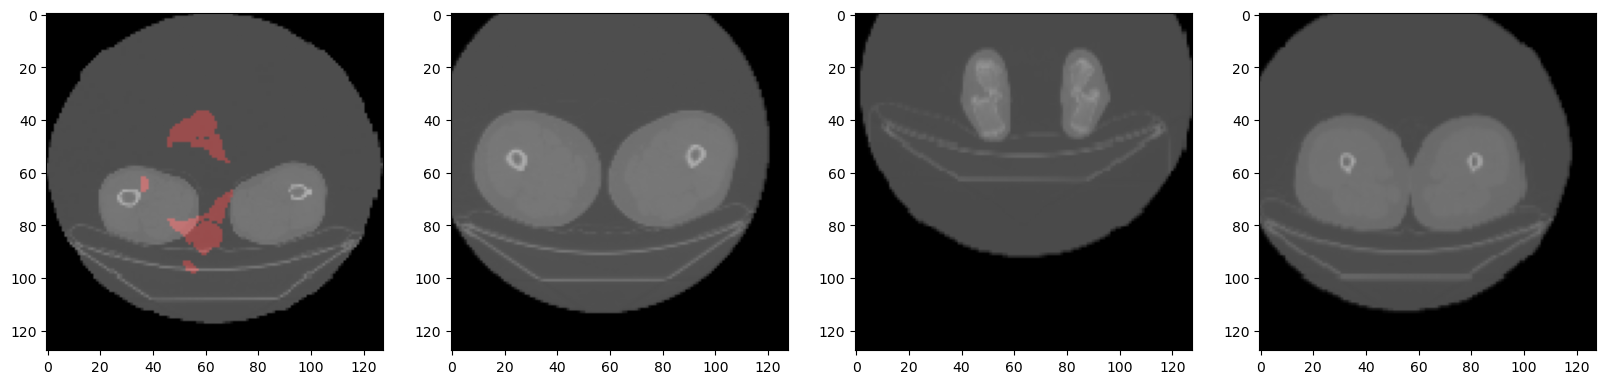

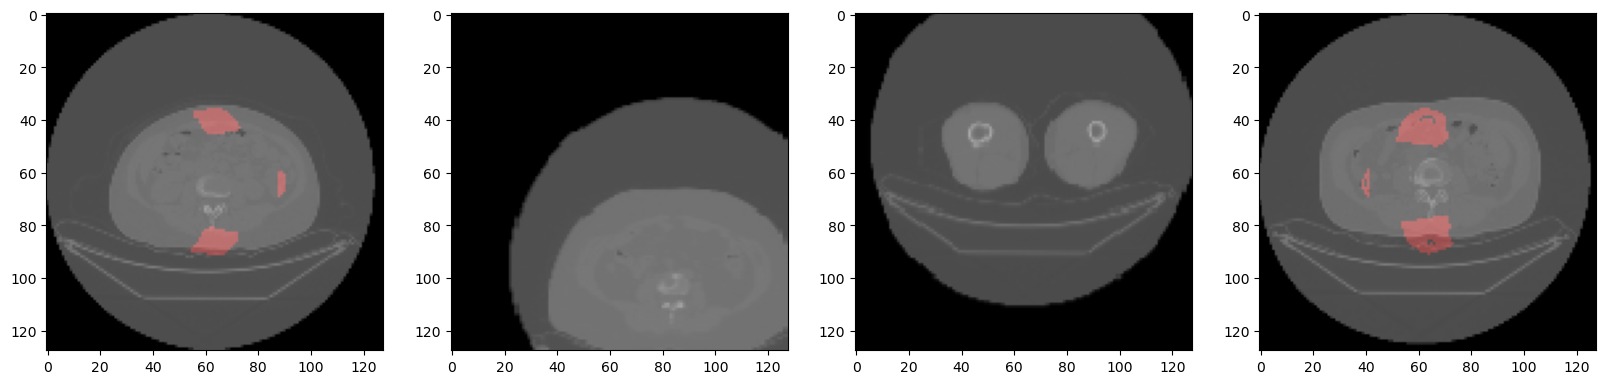

In [694]:
from glob import glob
for i in range(2):
    f, axarr = plt.subplots(1,4)
    for p in range(4):
        idx = i*4+p
        img, mask = dataset_show[idx]
        img = img[:, :, :, 60] 
        mask = mask[:, :, :, 60]
        mask[0] = mask[0] + mask[3] + mask[6]
        mask[1] = mask[1] + mask[4]
        mask[2] = mask[2] + mask[5]
        mask = mask[:3]
        # mask = mask.flip(dims=(1,))
        # mask = np.flip(mask, axis=1)
        # mask = np.rot90(mask, 1, axes=(1,2))  # Rotate on the last two axes
        img = img * 0.7 + mask * 0.3 
        axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())
        



Model

In [208]:
class TimmSegModel(nn.Module):
    def __init__(self, backbone, segtype='unet', pretrained=False):
        super(TimmSegModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=3,
            features_only=True,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            pretrained=pretrained
        )
        g = self.encoder(torch.rand(1, 3, 64, 64))
        encoder_channels = [1] + [_.shape[1] for _ in g]
        decoder_channels = [256, 128, 64, 32, 16]
        if segtype == 'unet':
            self.decoder = smp.unet.decoder.UnetDecoder(
                encoder_channels=encoder_channels[:n_blocks+1],
                decoder_channels=decoder_channels[:n_blocks],
                n_blocks=n_blocks,
            )

        self.segmentation_head = nn.Conv2d(decoder_channels[n_blocks-1], out_dim, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    def forward(self,x):
        global_features = [0] + self.encoder(x)[:n_blocks]
        seg_features = self.decoder(*global_features)
        seg_features = self.segmentation_head(seg_features)
        return seg_features

In [210]:
from timm.models.layers.conv2d_same import Conv2dSame
from conv3d_same import Conv3dSame


def convert_3d(module):

    module_output = module
    if isinstance(module, torch.nn.BatchNorm2d):
        module_output = torch.nn.BatchNorm3d(
            module.num_features,
            module.eps,
            module.momentum,
            module.affine,
            module.track_running_stats,
        )
        if module.affine:
            with torch.no_grad():
                module_output.weight = module.weight
                module_output.bias = module.bias
        module_output.running_mean = module.running_mean
        module_output.running_var = module.running_var
        module_output.num_batches_tracked = module.num_batches_tracked
        if hasattr(module, "qconfig"):
            module_output.qconfig = module.qconfig
            
    elif isinstance(module, Conv2dSame):
        module_output = Conv3dSame(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.Conv2d):
        module_output = torch.nn.Conv3d(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
            padding_mode=module.padding_mode
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.MaxPool2d):
        module_output = torch.nn.MaxPool3d(
        kernel_size=module.kernel_size,
        stride=module.stride,
        padding=module.padding,
        dilation=module.dilation,
        ceil_mode=module.ceil_mode,
        )
    elif isinstance(module, torch.nn.AvgPool2d):
        module_output = torch.nn.AvgPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            ceil_mode=module.ceil_mode,
        )

    for name, child in module.named_children():
        module_output.add_module(
            name, convert_3d(child)
        )
    del module

    return module_output


m = TimmSegModel(backbone)
m = convert_3d(m)
m(torch.rand(1, 3, 128,128,128)).shape

SyntaxError: invalid syntax (1345260318.py, line 2)

Loss & Metric

In [ ]:
from typing import Any, Dict, Optional


def binary_dice_score(
    y_pred: torch.Tensor,
    y_true: torch.Tensor,
    threshold: Optional[float] = None,
    nan_score_on_empty=False,
    eps: float = 1e-7,
) -> float:

    if threshold is not None:
        y_pred = (y_pred > threshold).to(y_true.dtype)

    intersection = torch.sum(y_pred * y_true).item()
    cardinality = (torch.sum(y_pred) + torch.sum(y_true)).item()

    score = (2.0 * intersection) / (cardinality + eps)

    has_targets = torch.sum(y_true) > 0
    has_predicted = torch.sum(y_pred) > 0

    if not has_targets:
        if nan_score_on_empty:
            score = np.nan
        else:
            score = float(not has_predicted)
    return score

def multilabel_dice_score(
    y_true: torch.Tensor,
    y_pred: torch.Tensor,
    threshold=None,
    eps=1e-7,
    nan_score_on_empty=False,
):
    ious = []
    num_classes = y_pred.size(0)
    for class_index in range(num_classes):
        iou = binary_dice_score(
            y_pred=y_pred[class_index],
            y_true=y_true[class_index],
            threshold=threshold,
            nan_score_on_empty=nan_score_on_empty,
            eps=eps,
        )
        ious.append(iou)

    return ious


def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


def bce_dice(input, target, loss_weights=loss_weights):
    loss1 = loss_weights[0] * nn.BCEWithLogitsLoss()(input, target)
    loss2 = loss_weights[1] * dice_loss(input, target)
    return (loss1 + loss2) / sum(loss_weights)

criterion = bce_dice

Train & Valid Function

In [ ]:
def mixup(input, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, truth, shuffled_labels, lam


def train_func(model, loader_train, optimizer, scaler=None):
    model.train()
    train_loss = []
    bar = tqdm(loader_train)
    for images, gt_masks in bar:
        optimizer.zero_grad()
        images = images.cuda()
        gt_masks = gt_masks.cuda()

        do_mixup = False
        if random.random() < p_mixup:
            do_mixup = True
            images, gt_masks, gt_masks_sfl, lam = mixup(images, gt_masks)

        with amp.autocast():
            logits = model(images)
            loss = criterion(logits, gt_masks)
        if do_mixup:
            loss2 = criterion(logits, gt_masks_sfl)
            loss = loss * lam  + loss2 * (1 - lam)

        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bar.set_description(f'smth:{np.mean(train_loss[-30:]):.4f}')

    return np.mean(train_loss)


def valid_func(model, loader_valid):
    model.eval()
    valid_loss = []
    outputs = []
    ths = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    batch_metrics = [[]] * 7
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for images, gt_masks in bar:
            images = images.cuda()
            gt_masks = gt_masks.cuda()

            logits = model(images)
            loss = criterion(logits, gt_masks)
            valid_loss.append(loss.item())
            for thi, th in enumerate(ths):
                pred = (logits.sigmoid() > th).float().detach()
                for i in range(logits.shape[0]):
                    tmp = multilabel_dice_score(
                        y_pred=logits[i].sigmoid().cpu(),
                        y_true=gt_masks[i].cpu(),
                        threshold=0.5,
                    )
                    batch_metrics[thi].extend(tmp)
            bar.set_description(f'smth:{np.mean(valid_loss[-30:]):.4f}')
            
    metrics = [np.mean(this_metric) for this_metric in batch_metrics]
    print('best th:', ths[np.argmax(metrics)], 'best dc:', np.max(metrics))

    return np.mean(valid_loss), np.max(metrics)

In [ ]:
rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000)
lrs = []
for epoch in range(1, 1000+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)

Train

In [ ]:
def run(fold):

    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{fold}_best.pth')

    train_ = df_seg[df_seg['fold'] != fold].reset_index(drop=True)
    valid_ = df_seg[df_seg['fold'] == fold].reset_index(drop=True)
    dataset_train = SEGDataset(train_, 'train', transform=transforms_train)
    dataset_valid = SEGDataset(valid_, 'valid', transform=transforms_valid)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = TimmSegModel(backbone, pretrained=True)
    model = convert_3d(model)
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=init_lr)
    scaler = torch.cuda.amp.GradScaler()
    from_epoch = 0
    metric_best = 0.
    loss_min = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs)

    print(len(dataset_train), len(dataset_valid))
    
    for epoch in range(1, n_epochs+1):
        scheduler_cosine.step(epoch-1)

        print(time.ctime(), 'Epoch:', epoch)

        train_loss = train_func(model, loader_train, optimizer, scaler)
        valid_loss, metric = valid_func(model, loader_valid)

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric > metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
run(0)
run(1)
run(2)
run(3)
run(4)